# CSCI 416 - HW3

### Name: Kyle Chen

# <font color='red'>Problem 3</font>


In [5]:
"""
=====================================
Test SVM with custom Gaussian kernels
=====================================


Author: Eric Eaton, 2014

Adapted from scikit_learn documentation.

"""
print(__doc__)

from numpy import loadtxt, ones, zeros, where
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from svmKernels import myGaussianKernel
from svmKernels import _gaussSigma

# import some data to play with

filename = 'data/svmTuningData.dat'
data = loadtxt(filename, delimiter=',')
X_raw = data[:, 0:-1]
Y_raw = np.squeeze(np.array([data[:, 2]]).T)
m, d = X_raw.shape
#print(m,d)

print("Training the SVMs...")

trials = 2
folds = 10
fold_size = m//folds
train_size = fold_size * (folds - 1)
#print(fold_size, train_size)
validation_size = fold_size



# Best parameters
best=[0,0,0]

# Search parameters through a grid 
#TODO: CHANGE THIS PART

sigma_vals = 10**np.arange(-3., 5.)
C_vals = np.linspace(1,100, num=100)

for c in range(0,100):
    for g in range(0,8):
      C = C_vals[c]
      _gaussSigma = sigma_vals[g]
      accuracy = 0
    
      for t  in range(0,trials):  
        
        #randomize the data set
        p = np.random.permutation(m)
        order = p[0:m]
        X = X_raw[order,:]
        Y = Y_raw[order]
    
        for f in range(0,folds):

            #cross validation: get train set and test set   
            # TODO 
            # You need to finish the following for cross validation
            r1, c1 = X.shape

            #get areas ahead and behind of testing data
            if(f == 0):
              X_train = X[(f+1)*(int)(r1/folds):,:]
              Y_train = Y[(f+1)*(int)(r1/folds):]
            elif f > folds - 1:
              X_train = X[:(f-1)*(int)(r1/folds),:]
              Y_train = Y[:(f-1)*(int)(r1/folds):]
            else:
              X_train = np.concatenate((X[:(f)*(int)(r1/folds),:], X[(f + 1)*(int)(r1/folds):,:]))
              Y_train = np.concatenate((Y[:(f)*(int)(r1/folds)], Y[(f + 1)*(int)(r1/folds):]))
            
            #print("training: ", X_train.shape)
            #number of values per fold is X.shape[0] / folds
            #multiply by f to get start
            X_test = X[(int)(f*r1 / folds) : (int)((f + 1)*r1 / folds), :]
            Y_test = Y[(int)(f*r1 / folds) : (int)((f + 1)*r1 / folds)]
 
            # create an instance of SVM with build in RBF kernel and train it
            equivalentGamma = 1.0 / (2 * _gaussSigma ** 2)
            model = svm.SVC(C=C, kernel='rbf', gamma=equivalentGamma)
            model.fit(X_train, Y_train)

            predictions_test = model.predict(np.c_[X_test[:,0],X_test[:,1]])
            a = np.mean(Y_test==predictions_test)
            accuracy += a
            
            
        # Best Accuracy So Far
        average_accuracy = accuracy/(folds*trials)
        if average_accuracy > best[2]:
            best[0] = C
            best[1] = _gaussSigma
            best[2] = average_accuracy
            

print(best)      


Test SVM with custom Gaussian kernels


Author: Eric Eaton, 2014

Adapted from scikit_learn documentation.


Training the SVMs...
[71.0, 10.0, 0.9846153846153847]


The best parameters are:  [71.0, 10.0, 0.9846153846153847]


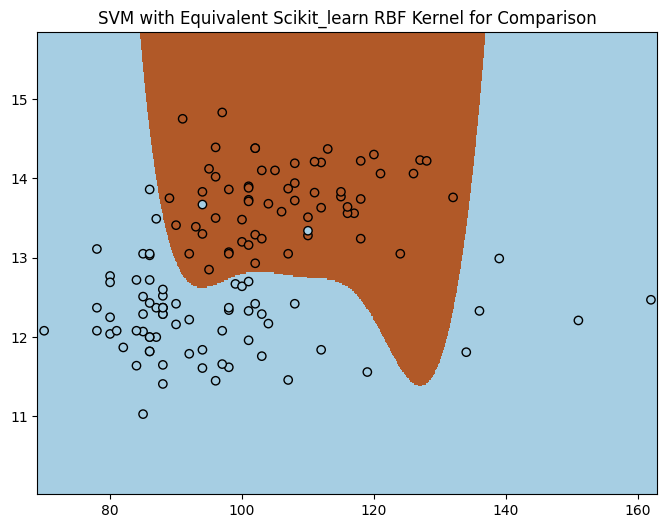

In [6]:
# create an instance of SVM with build in RBF kernel and train it
print("The best parameters are: ", best)
C = best[0]
_gaussSigma = best[1]
equivalentGamma = 1.0 / (2 * _gaussSigma ** 2)
model = svm.SVC(C=C, kernel='rbf', gamma=equivalentGamma)
model.fit(X, Y)

h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


predictions = model.predict(np.c_[xx.ravel(), yy.ravel()])
predictions = predictions.reshape(xx.shape)

# plot my results
plt.figure(figsize=(8, 6), dpi=100)

plt.pcolormesh(xx, yy, predictions, cmap="Paired")
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="Paired", edgecolors="black")  # Plot the training points
plt.title('SVM with Equivalent Scikit_learn RBF Kernel for Comparison')
plt.axis('tight')

plt.show()

 Report optimal values and the corresponding estimated accuracy. And explain how you find those optimal values.
 

 The optimal C value varies on initial run, but is between 50 and 80, with the corresponding gaussian sigma value being 10 in all cases. We find these values by checking the highest accuracy run and taking the values from that. For example, if the highest accuracy run of 98%, then we get the C and gaussian sigma value from that.

 In the latest case, then, we have C = 71.0, gaussian sigma = 10, and accuracy = 0.9846153846153847.

# <font color='red'>Problem 4</font>


$$
\renewcommand{\R}{\mathbb{R}}
\renewcommand{\b}{\mathbf}
\renewcommand{\u}{\mathbf{u}}
\renewcommand{\v}{\mathbf{v}}
$$


# Movie Recommendations


| user  | Moonlight | The Shape of Water   | Frozen | Moana     |
|-------|-----------|----------------------|--------|-----------| 
|Alice  |   5       |          4           |    1   |           |
|Bob    |           |          5           |        |    2      |
|Carol  |           |                      |        |    5      |
|David  |           |                      |    5   |    5      |
|Eve    |   5       |          4           |        |           |


What movie should I recommend to Bob?
Will Carol like Frozen?

**Goal**: Fill in entries of the "rating matrix"

# Problem Setup

Let's formalize this as a machine learning problem. To make it concrete, let's load some data and see what it looks like.

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import scipy.io

# Load train and test data
data = scipy.io.loadmat('movies.mat')

titles = [t[0] for t in data['movieData']['title'][0,0].ravel()]

for x,y in data.items():
    if isinstance(y, (np.ndarray)) and len(y)==1:
        data[x] = np.ndarray.item(y)#np.asscalar(y)
    elif isinstance(y, (np.ndarray)):
        data[x] = y.ravel()

nUsers    = data['nUsers']
nMovies   = data['nMovies']
userData  = data['userData']
movieData = data['movieData']

train_user   = data['train_user']-1   # matlab 1-index correction
train_movie  = data['train_movie']-1  # matlab 1-index correction
train_rating = data['train_rating']

valid_user   = data['valid_user']-1   # matlab 1-index correction
valid_movie  = data['valid_movie']-1  # matlab 1-index correction
valid_rating = data['valid_rating']

test_user    = data['test_user']-1    # matlab 1-index correction
test_movie   = data['test_movie']-1   # matlab 1-index correction


# Create a pandas data frame for training data to facilitate
# visualization and inspection

train_title = [titles[i] for i in train_movie]

train_data = pd.DataFrame(data = {'user_id' : train_user, 
                                  'movie_id' : train_movie,
                                  'rating' : train_rating,
                                  'title': train_title}, 
                         columns = ['user_id', 'movie_id', 'rating', 'title'])

# subsample to 5000 rows to more easily see a small sampling of ratings for each user
train_data = train_data[:5000]

# sort by user
train_data = train_data.sort_values(by=['user_id', 'rating'])

display(train_data)

,user_id,movie_id,rating,title
2070,0,242,1,Jungle2Jungle (1997)
2175,0,73,1,Faster Pussycat! Kill! Kill! (1965)
984,0,101,2,"Aristocats, The (1970)"
2400,0,236,2,Jerry Maguire (1996)
4364,0,179,3,Apocalypse Now (1979)
...,...,...,...,...
1373,942,61,3,Stargate (1994)
724,942,150,4,Willy Wonka and the Chocolate Factory (1971)
1883,942,23,4,Rumble in the Bronx (1995)
3403,942,731,4,Dave (1993)


## Training Data
As we can see, the training data presents observed entries of the "ratings" matrix as list of triples $(i_k, j_k, r_k)$ where

* $i_k$ is the user index of $k$th rating
* $j_k$ is the movie index of $k$th rating
* $r_k$ is the value of $k$th rating (1-5)

In our code we will store the entries of the tuples in three separate 1d arrays of the same length, so the $k$th rating is represented by the values ``train_user[k]``, ``train_movie[k]``, and ``train_rating[k]``.

## Problem Formulation

Now, let's formulate the problem mathematically. Suppose there are $m$ users and $n$ movies. 
Let $R$ be the $m \times n$ "rating" matrix, where $R_{ij}$ is the (possibly unknown) rating for user $i$ on movie $j$. 

Our training data gives us some of the entries of the rating matrix. Our goal
is to learn a parametric model to predict entries that we don't observe.

#### But Where are the Features?

What sort of predictive model can we use for entries of $R$? 

In past learning problems we had *feature vectors* and we learned *weight vectors* to make predictions (using dot products). 

Now we do not have feature vectors. What should we do?

## Matrix Factorization Model

Our solution is to **learn weight vectors for both users and movies**. 

Let $\u_i \in \R^d$ be the weight vector for use $i$ and $\v_j \in \R^d$ be the weight vector for movie $j$. Then we can predict the rating for user $i$ on movie $j$ as:

$$
H_{ij} =\u_i^T \v_j
$$

Our goal is to learn weight vectors for every user and movie so that $R_{ij} \approx H_{ij}$ for those entries of the rating matrix that we observe.

**Problem statement**: 
Given observed entries of the rating matrix presented as triples $(i_k, j_k, r_k)$ for $k=1, \ldots, n_{\text{train}}$, find weight vectors $\mathbf{u_i}$ for each user $i$ and $\mathbf{v}_j$ for each movie $j$ such that:
$$
r_k \approx \mathbf{u_{i_k}}^T \mathbf{v_{j_k}}, \quad k=1, 2, \ldots, n_{\text{train}}
$$

## Why is This Called Matrix Factorization?

* Place the user weight vectors $\u_i$ into the rows of a matrix
  $U$ and the movie feature vectors $\v_j$ into
  the rows of a matrix $V$

    $$ 
    \renewcommand{\line}{-}
    U =
        \begin{bmatrix}
            \line \u_1^T \line \\
            \line \u_2^T \line \\
            \ldots \\
            \line \u_m^T \line \\
        \end{bmatrix} \in \R^{m \times d}
    \qquad
    V =
        \begin{bmatrix}
            \line \v_1^T \line \\
            \line \v_2^T \line \\
            \ldots \\
            \line \v_n^T \line \\
        \end{bmatrix} \in \R^{n \times d}
    $$

* Consider the product $U V^T$:

    $$
    \boxed{
        \begin{array}{c}
            \\
            U \\
            \\
        \end{array}
        }
    \boxed{
        \begin{array}{c}
            \ \ \ V^T \ \ \ 
        \end{array}
        }
    $$
  
* It is easy to check that $(i,j)$ entry of $UV^T$ is equal to $\u_i^T
  \v_j$, which is our prediction for the $(i,j)$ entry of $R$

* In other words, our model is that $R \approx U V^T$ (a **factorization**
  of $R$)

* We choose $U$ and $V$ to get good predictions for those entries of
  $R$ that we can observe. As long as we don't overfit, this gives us
  power to generalize to entries we don't observe
  
* The "hidden dimension" $d$ (the length of each weight vector) is a hyperparameter
  that must be tuned with hold-out data.
  

## Your Job: Solve the Learning Problem 

* Formulate a squared error cost function corresponding to the problem statement above.
* Add regularization for *every* user weight vector $\u_i$ and movie weight vector $\v_j$ to get a regularized cost function
* Write down the partial derivatives of your regularized cost function with
  respect to the entries of $\u_i$ and $\v_j$
* Plug the partial derivatives into stochastic gradient descent (SGD)
  and write down the update rule
* Implement SGD
* Tune parameters (e.g., dimension $d$, regularization parameter) get good performance on the validation set

## Logistics


* Submit predictions on test set 
* Evaluation: root-mean squared error (RMSE) on test set

    $$ \text{RMSE} = \sqrt{\frac{1}{n_{\text{test}}}\sum_{(i,j) \in \text{test set}} (H_{ij} - R_{ij})^2}$$

* Your grade:

| RMSE   |  grade  |
|--------|---------|
|<= 1.0  |  80%    |
|<= 0.97 |  90%    |
|<= 0.95 |   95%   |
|<= 0.94 |  100%   ||



## (Review on your own) Model Extension: Add Biases

To get really great performance, consider this extended model for a predicted rating:

$$
H_{ij} = \mu + a_i + b_j + {\u}_i^T \v_j
$$

This adds several terms to the prediction for user $i$ on movie $j$:

* $\mu$ is an overall baseline rating. For example, the overall average rating of all users
  on all movies may be $\mu = 3.3$
  
* $a_i$ is a user-specific adjustment or "bias". For example, perhaps Alice
  really loves movies and gives them all high ratings. Then, her bias 
  might be $a_i = +0.4$. But Bob is hard to please, so his bias is $a_i = -0.7$.
  
* $b_j$ is a movie-specific bias. For example, perhaps Inside Out is universally
  loved, so its bias is $b_j = +0.7$. A really bad movie would have a negative bias.

The set of parameters of this model includes:

* $\mu$ 
* $a_i$, $i=1,\ldots, m$
* $b_j$, $j=1,\ldots, n$
* $\u_i \in \R^d$, $i=1,\ldots, m$
* $\v_j \in \R^d$, $j=1,\ldots, n$

To learn these parameters, derive partial derivatives of the regularized
cost function with respect to *all* of the above parameters, and update
them all within your stochastic gradient descent loop.

## Further Reading
[Matrix Factorization Techniques for Recommender
Systems](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)
by Yehuda Koren, Robert Bell and Chris Volinsky

* Authors were on the winning team of Netflix prize

* Paper includes algorithms---but beware different notation

## Step 0: Familiarize Yourself With Variables

Here are the variables we populated while loading the data above --- make sure you run that cell first.

In [ ]:
# 1) Metadata
#     
#     nUsers     # of users
#     nMovies    # of movies
#     titles     list of movie titles
#
#
# 2) Training data (60K ratings). This consists of three 1d arrays, 
#    each of length 60K:
#
#      train_user, train_movie, train_rating
#
#    The entries specify the ratings:
#   
#      train_user[k]    user index  of kth rating
#      train_movie[k]   movie index of kth rating
#      train_rating[k]  value (1-5) of kth rating
#
# 2) Validation data (20K ratings). Three vectors of length 20K:
#
#      valid_user, valid_movie, valid_rating
#   
#    Use this to evaluate your model and tune parameters.
#    
# 3) Test set (20K user-movie pairs without ratings):
#
#      test_user, test_movie
#
#    You will create predictions for these pairs and submit them for 
#    grading.

## Step 1: Look at the Prediction Method

To make things concrete, first take a look at the prediction method below. This is just a stub for now that returns the same value ``mu`` for every prediction. Later you will update this to make predictions given the weight vectors and biases.

In [179]:
def rmse(h, r):
    resid = h - r
    cost = np.sqrt(np.mean(resid**2))
    return cost

#users_original can be train_users, valid_users, test_users, etc.
#entries are ids of users, movies
def predict(mu, user_weights, movie_weights, users, movies, biasi, biasx):
    '''
    PREDICT Make predictions for user/movie pairs
    Inputs: 
      model parameters
      mu                          average rating
      user_weights                vector of user weights
      movie_weights               vector of movie weights
      users                       vector of user values
      movies                      vector of movie values
      biasi                       bias of i for user weights
      biasx                       bias of x for movie weights

    Output:
      predictions        vector of predictions
    '''    

    L = len(users)
    predictions = np.zeros(L)

    #user[k], movie[k] corresponds to rating[k]
    #rating[k] = range(0, 5)
    #user[i], movie[i] are integers to correspond to indices given by i = rating[k]
    #rxi = qipx + mu + bx + bi

    #get user, movie by passing in user matrix and 
    for k in range(0, L):                   #corresponds to 0-60k/0-20k
      #user[users_original[i]] #index for vector 'user' is users_original[i]
      #this returns a weight array q_i (u_i)

      #print(user_weights.shape)
      i = users[k]
      x = movies[k]
      uivx = np.dot(user_weights[i], movie_weights[x])#.T, movie_weights[x])

      predictions[k] = uivx + mu + biasi[i] + biasx[x]
    
    return predictions

## Step 2: Learning and Validation

Write code here to do the learning and validation. Stubs are provided. Make sure you derive the partial derivatives on paper before you try to code them. 

In [190]:
############################################
# Tunable parameters (you will add more)
############################################

nDims = 30

#added parameters
#l1 = 5e-3, l2 = 5e-3, lBi = 4e-3, lBx = 4e-3
#mu1 = 2e-3, mu2 = 2e-3, mu3 = 2e-3, mu4 = 2e-3
#iters = 50
#nDims = 30
#valid = 0.950

lambda1 = 5e-3
lambda2 = 5e-3
lambdaBiasI = 2e-4#4e-3
lambdaBiasX = 2e-4#4e-3

learningRate1 = 2.5e-3
learningRate2 = 2.5e-3
learningRate3 = 2.5e-3
learningRate4 = 2.5e-3

############################################
# Initialize parameters
############################################

mu = np.mean(train_rating)                # Mean ratings
a  = np.zeros(nUsers)                     # bias for users
b  = np.zeros(nMovies)                    # bias for movies
U  = np.random.randn(nUsers, nDims)  *.01 # User weights
V  = np.random.randn(nMovies, nDims) *.01 # Movie features (weights)

############################################
# Training and validation
############################################

# TODO: write code to train model and evaluate performance on validation set
#
#  predict() is a stub that predicts the overall mean for all user-movie
#  pairs. Update it to take more parameters and make real predictions.

#print(U.shape, V.shape)
iters = 40

#print(mu, train_user.shape, train_movie.shape, train_rating.shape)
#print(a.shape)
##print(U[0], V[0])

#SGD
#cost_history = []
for iterations in range(iters):
    #update user_weights, movie_weights, biases using GD
    epsilon = 0
    
    #Update U, V, a, b
    for k in range(len(train_rating)):
        i = train_user[k]
        x = train_movie[k]

        #mu is mean rating
        tempPredict = np.dot(U[i], V[x]) + mu + a[i] + b[x]#.T, V[x]) + mu + a[i] + b[x]
        epsilon = 2*(train_rating[k] - tempPredict)
        
        #ATTEMPT AT WRITING COST FUNCTION

        #regUi = lambda1*np.sum(np.dot(U[i].T, U[i]))
        #regVx = lambda2*np.sum(np.dot(V[x].T, V[x]))
        #regbx = lambdaBiasI*np.sum(a[i]*a[i])
        #regbi = lambdaBiasX*np.sum(b[x]*b[x])
        
        #if iterations % 10 == 0:
        #    cost_history.append(np.sum((epsilon / 2)*(epsilon / 2)) + 0.5 *(regUi + regVx + regbx + regbi))

        #print("epsilon: ", epsilon)
        U[i] = U[i] + learningRate1*(epsilon * V[x] - lambda1 * U[i])
        V[x] = V[x] + learningRate2*(epsilon * U[i] - lambda2 * V[x])
        a[i] = a[i] + learningRate3*(epsilon - lambdaBiasI * a[i])
        b[x] = b[x] + learningRate4*(epsilon - lambdaBiasX * b[x])
    #print(U.shape)
    
train_predictions = predict(mu, U, V, train_user, train_movie, a, b)
valid_predictions = predict(mu, U, V, valid_user, valid_movie, a, b)
train_rmse = rmse(train_predictions, train_rating)
valid_rmse = rmse(valid_predictions, valid_rating)

#print(U[0], V[0])

print('train_rmse=%.3f, valid_rmse=%.3f' % (train_rmse, valid_rmse))

############################################
# Testing
############################################

# Make and save predictions for test set
test_predictions = predict(mu, U, V, test_user, test_movie, a, b)
np.savetxt('test_predictions.txt', test_predictions)

#plt.plot(cost_history)
#plt.show()

train_rmse=0.835, valid_rmse=0.923


## Bonus Material: Inspect Predictions for Different Users

After you have learned a good model, you may wish to interpret what it has learned. We can do this by looking at the most positive and most negative predictions for different users
(or the movies that are bumped up or down from the baseline the most).

Read and run the code below to see if you can understand the predictions. (Note: the predictions won't make sense until you have learned a good model!)

In [ ]:
all_movies = range(nMovies)

def get_lowest(vals):
    most_negative = np.argsort(vals)
    return most_negative

def get_highest(vals):
    most_negative = np.argsort(vals)
    most_positive = most_negative[::-1]
    return most_positive

k = 8
all_users = range(nUsers)
users_to_examine = all_users[0:5]

for user in users_to_examine:

    # Changes from baseline movie predictions for this user
    delta = np.dot(V, U[user,:])  

    print('*** User %d ***' % (user))
    print('  Top movies')
    for i in get_highest(delta)[0:k]:
        print('    %+.4f  %s' % (delta[i], titles[i]))
    print('')
    
    print('  Bottom movies')
    for i in get_lowest(delta)[0:k]:
        print('    %+.4f  %s' % (delta[i], titles[i]))
    print('')


## More Bonus Material: Interpretation of Weight Vectors as Features

* So far we have described both $\u_i$ and $\v_j$ as *weight vectors* (since we don't have any features of movies and users). But, it is possible to interpret one or both of these vectors as **learned features**. 

* For example, the first learned feature may discover a preference for comedy vs. drama. In this case:
    * The user feature value $u_{i1}$ should be high if the user likes comedies and low if the user likes dramas better.
    * The movie feature value $v_{j1}$ should be high if the movie is a comedy and low if it is a drama. 
    
* Similarly, feature 2 might describe whether a movie is geared toward kids or adults

* In practice, the feature interpretations often find recognizable patterns but are not quite so clean to describe as the two examples above.

Run the code below to examine the movies with the highest and lowest feature values for some of the features in your learned model.

In [ ]:
k = 5

features_to_examine = np.arange(0,10)

for feature in features_to_examine:

    feature_vals = V[:,feature]
    
    print ('*** Feature %d ***' % (feature))
    print ('  Movies with highest feature value')
    for i in get_highest(feature_vals)[0:k]:
        print ('    %+.4f  %s' % (feature_vals[i], titles[i]))
    print ('')
    
    print ('  Movies with lowest feature value')
    for i in get_lowest(feature_vals)[0:k]:
        print ('    %+.4f  %s' % (feature_vals[i], titles[i]))
    print ('')
